In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import math

In [2]:
# user variables
wave_freq = 100.0 #Hz
cycles = 5
samplerate = 48000

# conversions / calculations
duration = cycles / wave_freq #sec
duration_ms = duration * 1000.0 #msec
lengthInSamps = math.ceil(duration * samplerate)

# create time axis
time = np.linspace(0, duration, lengthInSamps)

# choose a waveform
#wave = signal.sawtooth(2.0*np.pi*wave_freq*time)
wave = signal.square(2.0*np.pi*wave_freq*time, duty=(2.0*np.pi*time + 1)/2)

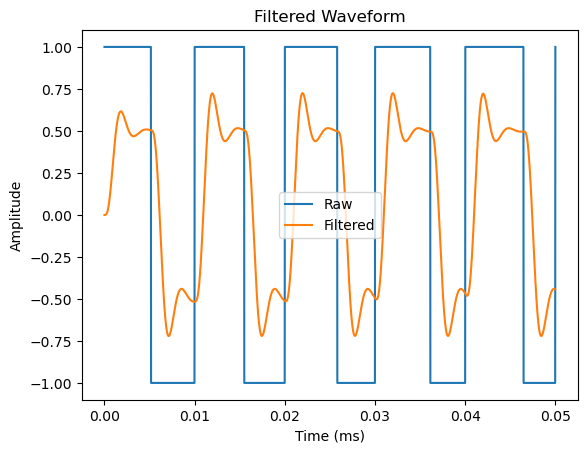

Maximum iterations: 3


In [16]:
# filter parameters
input_gain = 1.0
cutoff = 500.0
r = 1.0 # resonance (0.0 to 4.0)

g = np.tan(cutoff * np.pi / samplerate)
boosted_wave = wave * input_gain

# initial values
y = np.array([0.0, 0.0, 0.0, 0.0])  # inital guess
errorThresh = 0.000001 # max NR error (stopping condition)
maxIter = 0
filtered_wave = np.zeros(len(boosted_wave))

# state values (initially zero)
s1 = 0.0
s2 = 0.0
s3 = 0.0
s4 = 0.0


# NR loop
for n in range(len(boosted_wave)):
    # input (current sample)
    x = boosted_wave[n]
    
    i = 0
    residue = 100 # something large
    while(abs(residue) > errorThresh and i < 50):

        # F(y) using current y values
        y1 = g*np.tanh(x - y[0] - r*y[3]) + s1 - y[0]
        y2 = g*np.tanh(y[0] - y[1]) + s2 - y[1]
        y3 = g*np.tanh(y[1] - y[2]) + s3 - y[2]
        y4 = g*np.tanh(y[2] - y[3]) + s4 - y[3]
        F = np.array([y1, y2, y3, y4]).T

        # Jacobian Matrix
        J = np.array([
            [-g*(1.0 - np.tanh(x - y[0] - r*y[3])**2) -1.0, 0.0, 0.0, -g*r*(1.0 - np.tanh(x - y[0] - r*y[3])**2)],
            [g*(1.0 - np.tanh(y[0] - y[1])**2), -g*(1.0 - np.tanh(y[0] - y[1])**2) - 1.0, 0.0, 0.0],
            [0.0, g*(1.0 - np.tanh(y[1] - y[2])**2), -g*(1.0 - np.tanh(y[1] - y[2])**2) - 1.0, 0.0],
            [0.0, 0.0, g*(1.0 - np.tanh(y[2] - y[3])**2), -g*(1.0 - np.tanh(y[2] - y[3])**2) - 1.0]])


        # calculate next NR step
        y_est = y
        y = y - np.matmul(inv(J), F)
        residue = y[3] - y_est[3] # only care about y4 residue
        i = i + 1
    
    # save y
    filtered_wave[n] = y[3]
    
    # update states
    s1 = 2.0 * y[0] - s1
    s2 = 2.0 * y[1] - s2
    s3 = 2.0 * y[2] - s3
    s4 = 2.0 * y[3] - s4
    
    # log max iterations
    if i > maxIter:
        maxIter = i
    
# plot waveform 
plt.plot(time, wave, label="Raw")
plt.plot(time, filtered_wave, label="Filtered")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Filtered Waveform")
plt.legend()
plt.show()

# print max iterations
print("Maximum iterations: " + str(maxIter))

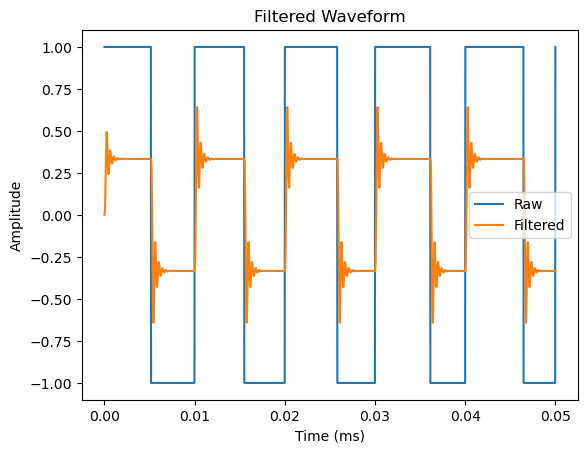

Maximum iterations: 1


In [20]:
# filter parameters
input_gain = 1.0
cutoff = 3000.0
r = 2.0 # resonance (0.0 to 4.0)

g = np.tan(cutoff * np.pi / samplerate)
boosted_wave = wave * input_gain


# initial values
y = np.array([0.0, 0.0, 0.0, 0.0])  # inital guess
errorThresh = 0.000001 # max NR error (stopping condition)
maxIter = 0
filtered_wave = np.zeros(len(boosted_wave))

# state values (initially zero)
s1 = 0.0
s2 = 0.0
s3 = 0.0
s4 = 0.0


# NR loop
for n in range(len(boosted_wave)):
    # input (current sample)
    x = boosted_wave[n]
    
    i = 0
    residue = 100 # something large
    while(abs(residue) > errorThresh and i < 50):
        # pre-compute tanh functions
        tanh_y1 = np.tanh(x - y[0] - r*y[3])
        tanh_y2 = np.tanh(y[0] - y[1])
        tanh_y3 = np.tanh(y[1] - y[2])
        tanh_y4 = np.tanh(y[2] - y[3])
        
        # F(y) using current y values
        y1 = g*tanh_y1 + s1 - y[0]
        y2 = g*tanh_y2 + s2 - y[1]
        y3 = g*tanh_y3 + s3 - y[2]
        y4 = g*tanh_y4 + s4 - y[3]
        F = np.array([y1, y2, y3, y4]).T

        # pre-compute re-used algebra (helper "functions")
        help_y1 = 1.0 - (tanh_y1 * tanh_y1)
        help_y2 = 1.0 - (tanh_y2 * tanh_y2)
        help_y3 = 1.0 - (tanh_y3 * tanh_y3)
        help_y4 = 1.0 - (tanh_y4 * tanh_y4)
        
        # Jacobian Matrix Elements
        j00 = -g*help_y1 - 1.0
        j03 = -g*r*help_y1
        j10 = g*help_y2
        j11 = -g*help_y2 - 1.0
        j21 = g*help_y3
        j22 = -g*help_y3 - 1.0
        j32 = g*help_y4
        j33 = -g*help_y4 - 1.0
        den = j00*j11*j22*j33 - j03*j10*j21*j32

        # calculate next NR step
        y_est = y

        y[0] = y[0] + (F[1]*j03*j21*j32 - F[0]*j11*j22*j33 - F[2]*j03*j11*j32 + F[3]*j03*j11*j22) / den
        y[1] = y[1] + (F[0]*j10*j22*j33 - F[1]*j00*j22*j33 + F[2]*j03*j10*j32 - F[3]*j03*j10*j22) / den
        y[2] = y[2] + (F[1]*j00*j21*j33 - F[0]*j10*j21*j33 - F[2]*j00*j11*j33 + F[3]*j03*j10*j21) / den
        y[3] = y[3] + (F[0]*j10*j21*j32 - F[1]*j00*j21*j32 + F[2]*j00*j11*j32 - F[3]*j00*j11*j22) / den

        residue = y[3] - y_est[3] # only care about y4 residue
        i = i + 1
    
    # save y
    filtered_wave[n] = y[3]
    
    # update states
    s1 = 2.0 * y[0] - s1
    s2 = 2.0 * y[1] - s2
    s3 = 2.0 * y[2] - s3
    s4 = 2.0 * y[3] - s4

    
    # log max iterations
    if i > maxIter:
        maxIter = i
    
# plot waveform 
plt.plot(time, wave, label="Raw")
plt.plot(time, filtered_wave, label="Filtered")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Filtered Waveform")
plt.legend()
plt.show()
#plt.savefig('square1.png')

# print max iterations
print("Maximum iterations: " + str(maxIter))